## Mr Haulage Data Analysis and Cleaning

Contained in this notebook is the inital data analysis for the Techmodal Mr Haulage problem

### Libraries

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
from collections import Counter,OrderedDict
import seaborn as sns
import openpyxl
from itertools import islice

sns.set()

### Data Loading

**Note:** Before loading the data in, we converted the data to csv format, from excel worksheet. This makes loading the data in to pandas easier.

In [117]:
#Instantiate dataframe containing order data
orders_df = pd.read_excel("../data/case/Mr Haulage Order Data.xlsx")

In [118]:
#Inspect data
orders_df.head()

,Order ID,Customer ID,Order Date,Order Time,Item Serial,Box Type,Delivery Region,Distance (miles)
0,1097342,733603,22/08/2021,00:14,30351,Small,South East,70
1,1097343,405061,22/08/2021,07:08,17634,Small,Greater London,32
2,1097344,842139,22/08/2021,10:15,25598,Small,South West,190
3,1097345,211806,22/08/2021,17:05,10104,Small,South West,85
4,1097346,103222,22/08/2021,23:48,3252,Small,Greater London,43


### Data Manipulation

First of all, we wish to remove `Order ID` and `Item Serial`, since these are only ID numbers and will likely lack useful predictive information. We keep `Customer ID` since there may be a relationship between what customers are more likely to order each box type.

In [119]:
orders_df = orders_df.drop(columns=['Order ID', 'Item Serial'])

We consider whether there are any other null values in the dataframe

In [120]:
orders_df.isna().any()

Customer ID         False
Order Date          False
Order Time          False
Box Type            False
Delivery Region     False
Distance (miles)    False
dtype: bool

From this we infer our data is now cleaned of null values, and so we proceed to view our cleaned dataframe.

In [121]:
orders_df.head()

,Customer ID,Order Date,Order Time,Box Type,Delivery Region,Distance (miles)
0,733603,22/08/2021,00:14,Small,South East,70
1,405061,22/08/2021,07:08,Small,Greater London,32
2,842139,22/08/2021,10:15,Small,South West,190
3,211806,22/08/2021,17:05,Small,South West,85
4,103222,22/08/2021,23:48,Small,Greater London,43


Finally, we sort our dataframe by the date.

In [122]:
orders_df['Order Date'] = pd.to_datetime(orders_df['Order Date'], format = "%d/%m/%Y")

### Predictor Analysis

This section contains inital data analysis. Here we try and learn more about distributions and anything that can inform our modelling procedures.

We first would like to get an understanding about frequency of which box size occurs

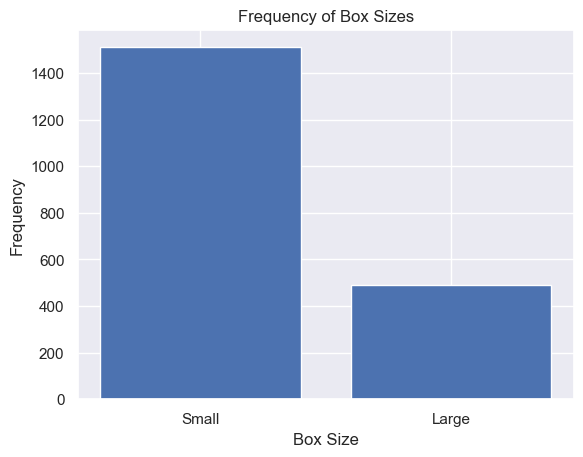

In [123]:
box_size_freq = Counter(orders_df["Box Type"])

plt.bar(box_size_freq.keys(), box_size_freq.values())

plt.xlabel('Box Size')
plt.ylabel('Frequency')
plt.title('Frequency of Box Sizes')
          
plt.show()

We observe that small boxes are shipped more than double the amount of the large boxes. In the 2000 data entries we have however, the ~400 Large boxes still are in significant number.

Next we wish to visualise the distances at which orders are typically shipped.

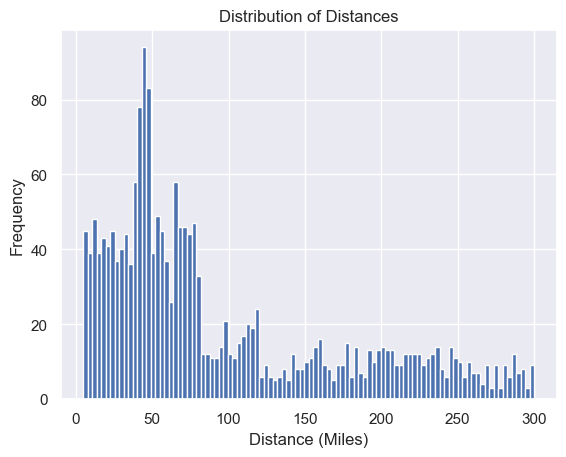

In [124]:
plt.hist(orders_df["Distance (miles)"], bins = 100)

plt.xlabel('Distance (Miles)')
plt.ylabel('Frequency')
plt.title('Distribution of Distances')
          
plt.show()

We find that most orders are sub 75 miles, and then the distribution flattens out pretty sharply. We can use this to infer that the region likely has an impact on the quantity of monthly orders.

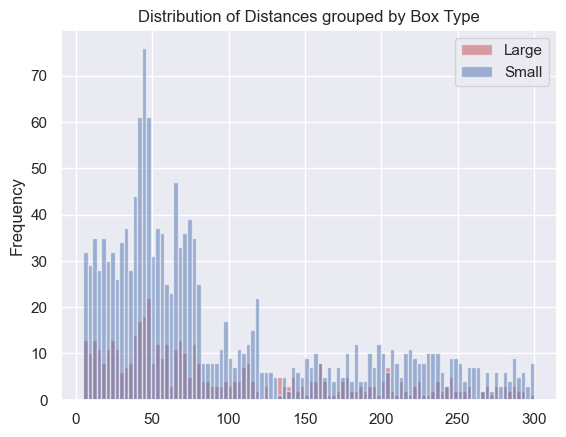

In [125]:
x1 = orders_df.loc[orders_df["Box Type"] == 'Large', 'Distance (miles)']
x2 = orders_df.loc[orders_df["Box Type"] =='Small', 'Distance (miles)']

plt.hist(x1, bins = 100, alpha = 0.5, color='r', label='Large')
plt.hist(x2, bins = 100, alpha = 0.5, color='b', label='Small')

plt.gca().set(title='Distribution of Distances grouped by Box Type', ylabel='Frequency')
plt.legend()

plt.show()

We see that there is a smiliar distribution regardless of box type, so we can say that order location likely has a limited impact on the type of order.

With this is mind, we now attempt to understand where our most popular clients are based, we do this through a simple bar chart.

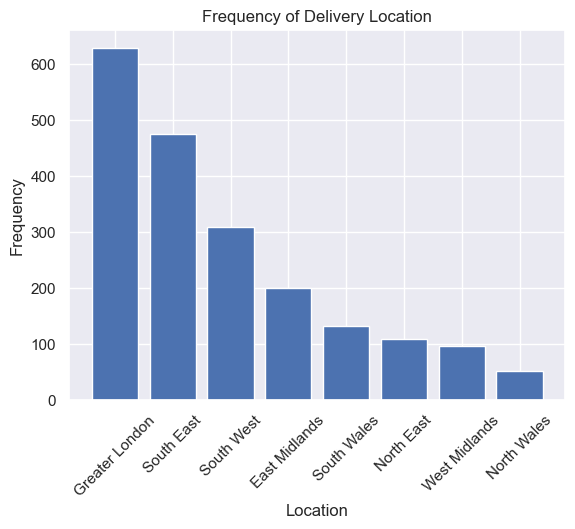

In [126]:
location_freq = OrderedDict(Counter(orders_df["Delivery Region"]).most_common())

plt.bar(location_freq.keys(), location_freq.values())

plt.xticks(rotation = 45)
plt.xlabel('Location')
plt.ylabel('Frequency')
plt.title('Frequency of Delivery Location')
          
plt.show()

Here we observe that by far the most delivered too area is Greater London, and the least is North Wales. The south of England is far more common that than the northern areas.

Next, we wish to see if there is any pattern in the time of day orders are placed.

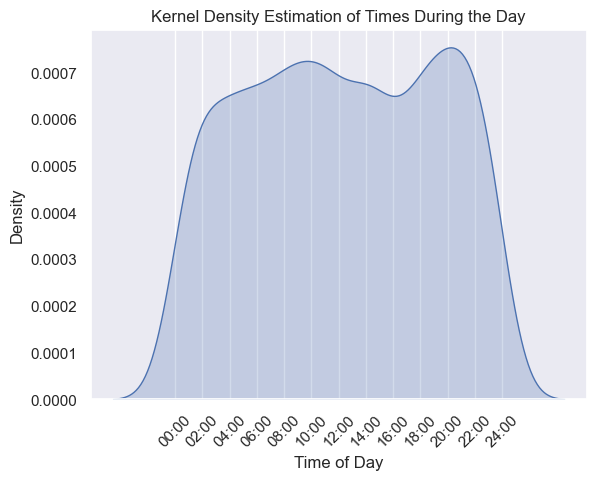

In [127]:
#First convert times to minutes after midnight
minutes_after_midnight = [(int(h) * 60 + int(m)) for h, m in (time.split(':') for time in orders_df['Order Time'])]

#Plot KDE
sns.kdeplot(minutes_after_midnight, fill=True, bw_method='scott') 
plt.xlabel('Time of Day')
plt.ylabel('Density')
plt.title('Kernel Density Estimation of Times During the Day')

#Convert back to HH:MM format
plt.xticks([i * 60 for i in range(0, 25, 2)], [f"{i:02d}:00" for i in range(0, 25, 2)], rotation = 45)

plt.grid(axis='y')
plt.show()

We observe no real relationship with the quantity of orders and the time of day. We only see that it is pretty consistent throughout the day.

Finally, we wish to see if there is any relationship between what customers are ordering, using their customer ID

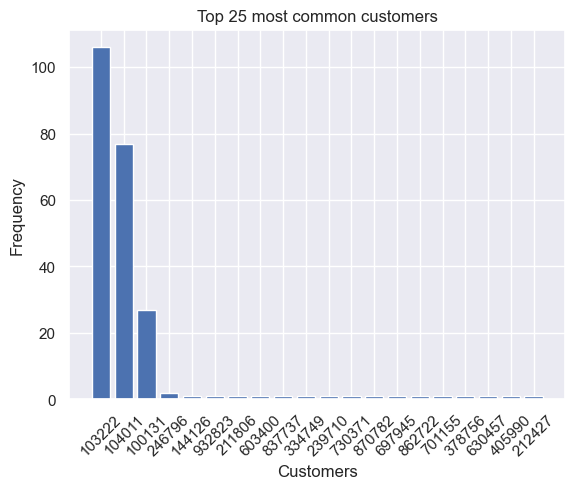

In [128]:
customer_freq = orders_df['Customer ID'].astype("string").value_counts().nlargest(20)

plt.bar(customer_freq.index, customer_freq.values)
plt.title('Top 25 most common customers')
plt.ylabel('Frequency')
plt.xlabel('Customers')
plt.xticks(rotation=45)
plt.show()

We observe that a large proportion of the orders are placed by just 3 customers, the rest are unique. Since most of the customers are unique, we can say that there is likely limited information in `Customer ID`. Despite this, we will explore a little further. 

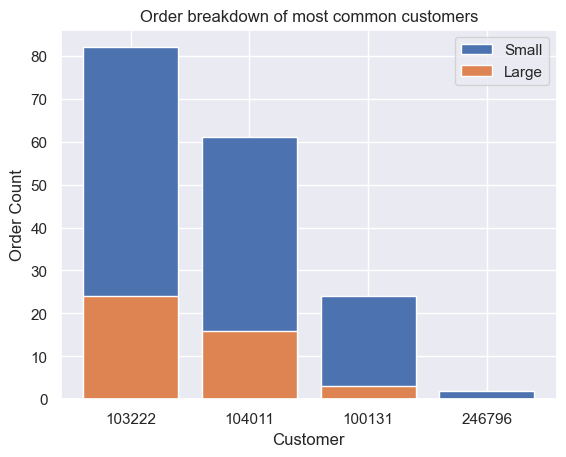

In [129]:
top_3_customers = orders_df[orders_df['Customer ID'].isin([103222, 104011, 100131, 246796])]

large2 = top_3_customers.loc[top_3_customers["Box Type"] == 'Large', 'Customer ID'].value_counts()
small2 = top_3_customers.loc[top_3_customers["Box Type"] == 'Small', 'Customer ID'].value_counts()

plt.bar(small2.index.astype("string"), small2.values, label = "Small")
plt.bar(large2.index.astype("string"), large2.values, label = "Large")

plt.gca().set(title='Order breakdown of most common customers', ylabel='Order Count', xlabel = 'Customer')
plt.legend()

plt.show()

As we can see, the ratio of large orders to small order remains pretty constant regardless of the customer, as such there is likely not much useful information here either.

From our analysis, we can start removing features that are likely unimportant when determining the type and order quantity over the next few years. We will remove `Order Time`, `Distance (miles)`, `Delivery Region` and `Customer ID`.

In [130]:
orders_df = orders_df.drop(columns=['Distance (miles)', 'Order Time', 'Delivery Region', 'Customer ID'])

### Time Series Analysis

Finally, for our forecast, we wish to determine the quantity of orders and their type, per day.

In [131]:
box_type_count = orders_df.pivot_table(index='Order Date', columns='Box Type', aggfunc='size', fill_value=0)
box_type_count["Total"] = box_type_count["Large"] + box_type_count["Small"]
box_type_count.head()

Box Type,Large,Small,Total
Order Date,,,
2021-08-22,0,6,6
2021-08-23,3,4,7
2021-08-24,3,7,10
2021-08-25,1,6,7
2021-08-26,3,3,6


We first set our index to a `datetime` format for ease of plotting.

In [132]:
box_type_count.index = pd.DatetimeIndex(box_type_count.index).to_period('D')

Next, we compute a moving average to assess if there is any pattern in the time series.

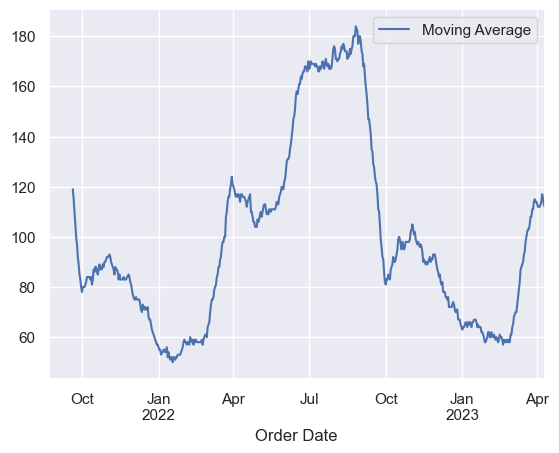

In [136]:
box_type_count['Moving Average'] = box_type_count['Total'].rolling(30).sum()
box_type_count.plot(y = "Moving Average")

plt.show()

At last it appears as though we have found some pattern in the data. We see there seems to be a spike in orders around the summer time, and a trough in January. We break this down further.

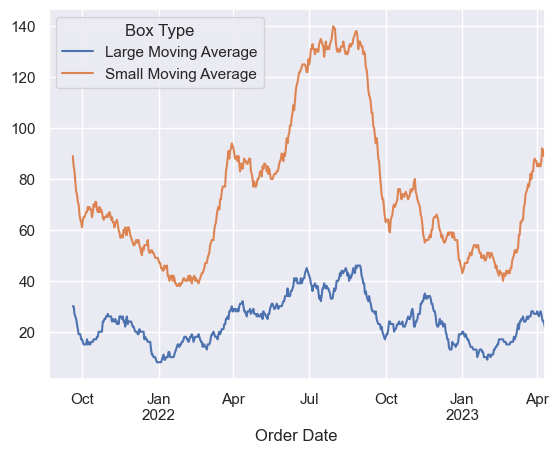

In [135]:
box_type_count['Small Moving Average'] = box_type_count['Small'].rolling(30).sum()

box_type_count['Large Moving Average'] = box_type_count['Large'].rolling(30).sum()

box_type_count.plot(y = ["Large Moving Average", "Small Moving Average"])

plt.show()

We see that although the seasonality is stronger in the small box types, the large box types also experience this seasonality.

Since we have a seasonal component, and our dataset is not that large, we intend to fit a simpler model, such as an ARIMA. The forecasting is documented in the next notebook `Forecasting.ipynb`

### Save Data

Finally we write our clean data to a dataframe

In [138]:
box_type_count.to_csv('../data/clean/orders.csv', index=True)